week8 objectives:

1. extract visual and acoustic features from ryerson dataset samples
2. fetch action units from facial expressions
3. extract mel-frequency cepstral coefficients from audio
4. extract low-level acoustic features

In [1]:
!module load FFmpeg

In [2]:
import os
from tqdm import tqdm

BASE_PATH = '/'.join(os.getcwd().split('/')[ : -2])

DATA_PATH = "gallina/ryerson/audio"
FEATURES_PATH = "feature/"

import cv2
import librosa

import numpy as np


In [3]:
def get_audio_duration(PATH):
    '''average duration of audios'''
    f_names = os.listdir(PATH)

    print(sum(librosa.core.get_duration(path=os.path.join(PATH, f))
              for f in tqdm(f_names, desc="computing the average duration of the audios")) / len(f_names))

get_audio_duration(os.path.join(BASE_PATH, DATA_PATH, "Actor_01"))

computing the average duration of the audios: 100%|██████████| 60/60 [00:01<00:00, 36.70it/s]

3.749855902777779


In [3]:
def get_duration(path):
    cap = cv2.VideoCapture(path)

    # number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    a = frames / fps

    # print(f"duration: {a} sec", f"frames: {frames}")
    return a, frames


In [3]:
durations, frames = [], []

for dir in os.listdir(DATA_PATH):
    # iterate over files
    for f in os.listdir(os.path.join(DATA_PATH, dir)):

        a, b = get_duration(os.path.join(DATA_PATH, dir, f))

        durations.append(a)
        frames.append(b)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<Axes: >

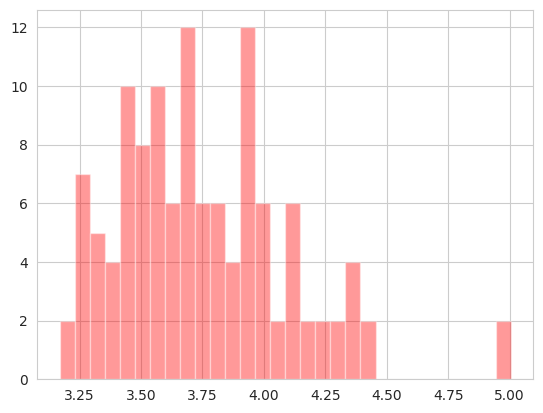

In [10]:
sns.set_style('whitegrid')
sns.distplot(durations, kde = False, color ='red', bins = 30)

In [ ]:
from feat import Detector

detector = Detector()

not_cols = ['frame', 'FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight', 'FaceScore', 'input', 'frame', 'approx_time']

cols = ['Pitch', 'Roll', 'Yaw', 'AU01', 'AU02', 'AU04', 'AU05', 'AU06', 'AU07', 'AU09', 'AU10', 'AU11', 
        'AU12', 'AU14', 'AU15','AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26', 'AU28', 'AU43']


In [4]:
def extract_visual(path, skip=2):
    '''extract facial features'''
    video_prediction = detector.detect_video(path, skip_frames=skip)

    # df = video_prediction.drop(cols, axis=1)
    df = video_prediction[cols]
    
    return list(df.sum(axis=0).values)

In [5]:
# feature extraction - AUs

feats, label = [], []

for dir in os.listdir(DATA_PATH):
    # iterate over files
    for f in os.listdir(os.path.join(DATA_PATH, dir))[ : 50]:

        feats.append(extract_visual(os.path.join(DATA_PATH, dir, f), skip=8))
        # fetch label
        label.append(int(f.split('-')[2]))


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


In [12]:
np.save(os.path.join(DATA_PATH, "feat"), np.array(feats))

np.save(os.path.join(DATA_PATH, "label"), np.array(label))


In [16]:
import opensmile

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,  # emobase
    feature_level=opensmile.FeatureLevel.Functionals,
)


In [17]:
feat_i = smile.process_file(os.path.join(BASE_PATH, DATA_PATH, "Actor_01/03-01-01-01-01-01-01.wav"))

feat_i.shape

(1, 6373)

In [5]:
# feat_i = feat_i.loc[:, ~feat_i.columns.isin(['file', 'start', 'end'])]

feat_i = feat_i.values.tolist()[0]

In [24]:
import librosa

def extract_mfcc(path, mfcc=True):
    '''extract MFCC'''
    x, sample_rate = librosa.load(path)
    
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=120).T, axis=0)
        result=np.hstack((mfccs))

        return result
    else:
        return None


def extract_librosa_features(path):
    '''extract stack of features'''
    x, sample_rate = librosa.load(path)

    hop_length = 512  # set hop length; at 22050 Hz, 512 samples ~= 23ms

    # remove vocals
    d = librosa.stft(x, hop_length=hop_length)
    s_full, phase = librosa.magphase(d)

    s_filter = librosa.decompose.nn_filter(s_full, aggregate=np.median, metric='cosine',
                                           width=int(librosa.time_to_frames(0.2, sr=sample_rate)))

    s_filter = np.minimum(s_full, s_filter)

    power, margin_v = 2, 4

    mask_v = librosa.util.softmask(s_full - s_filter, margin_v * s_filter, power=power)
    s_foreground = mask_v * s_full

    # recreate vocal_removal y
    new_d = s_foreground * phase
    x = librosa.istft(new_d)

    mfcc = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=13)  # MFCC features from raw
    mfcc_delta = librosa.feature.delta(mfcc)  # first-order differences (delta features)

    s = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_mels=128, fmax=8000)
    s_delta = librosa.feature.delta(s)

    spectral_centroid = librosa.feature.spectral_centroid(S=s_full)

    audio_feature = np.vstack((mfcc, mfcc_delta, s, s_delta, spectral_centroid))  # combine features

    # binning data
    jump = int(audio_feature.shape[1] / 10)
    return np.mean(librosa.util.sync(audio_feature, range(1, audio_feature.shape[1], jump)).T, axis=0)  # mean


In [25]:
feat_i = extract_librosa_features(os.path.join(BASE_PATH, DATA_PATH, "Actor_01/03-01-01-01-01-01-01.wav"))

In [26]:
feat_i.shape

(283,)

main: set up a script to extract action units, mel-frequency cepstral coefficients and low-level acoustic features from ryerson dataset

script: pynb/w8/extract.py